# Evaluation в GigaLogger
В этом ноутбуке мы произведем оценку нашего RAG'а с помощью датасета и мощной LLM (gpt-4o)
И не только! Мы также замерим качество ответов на обычном GigaChat (без RAG), с обычным RAG, Adaptive RAG и нашу версию RAG.
У нас в боте используется измененный Adaptive RAG.
Предыдущие шаги:
1. [Генерация синтетического датасета](1_generate_dataset.ipynb)
2. [Загрузка датасета в GigaLogger](2_gigalogger_create_dataset.ipynb)

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
import getpass

def get_env_var(var_name):
    if var_name in os.environ:
        return os.environ[var_name]
    else:
        return getpass.getpass(f"Enter {var_name}: ")

import sys
sys.path.append("..")  # Add the parent folder to the sys.path

load_dotenv(find_dotenv())
os.environ["LANGFUSE_HOST"] = "https://gigalogger.demo.sberdevices.ru"
os.environ["LANGFUSE_PUBLIC_KEY"] = get_env_var("LANGFUSE_PUBLIC_KEY")
os.environ["LANGFUSE_SECRET_KEY"] = get_env_var("LANGFUSE_SECRET_KEY")

In [3]:
from langfuse import Langfuse
langfuse = Langfuse()

## Цепочка для оценки ответов

Определим промпты для оценки ответов
Мы будем оценивать по следующим критериям:
- Похожи ли ответ нашей цепочки и корректный ответ (из датасета)
- Содержит ли ответ информацию из документов, которые мы нашли с помощью RAG
- Есть ли в ответе ссылки из документов (или из стандартного раздела ссылок)

In [4]:
from langchain_core.prompts import PromptTemplate
COT_PROMPT = PromptTemplate(
    input_variables=["query", "context", "result"], template="""Ты учитель, оценивающий тест.

Тебе дан вопрос, корректный ответ и ответ студента. Тебе нужно оценить ответ студента как ПРАВИЛЬНЫЙ или НЕПРАВИЛЬНЫЙ, основываясь на корректном ответе.
Опиши пошагово своё рассуждение, чтобы убедиться, что твой вывод правильный. Избегай просто указывать правильный ответ с самого начала.

Вот базовая информация из конкретной области этого теста:
GigaChat - это большая языковая модель (LLM) от Сбера.
GigaChat API (апи) - это API для взаимодействия с GigaChat по HTTP с помощью REST запросов.
GigaChain - это SDK на Python для работы с GigaChat API. Русскоязычный форк библиотеки LangChain.
GigaGraph - это дополнение для GigaChain, который позволяет создавать мультиагентные системы, описывая их в виде графов.
Обучение GigaChat выполняется командой разработчиков. Дообучение и файнтюнинг для конечных пользователей на данный момент не доступно.
Для получения доступа к API нужно зарегистрироваться на developers.sber.ru и получить авторизационные данные.

Опирайся на эту базовую информацию, если тебе не хватает информации для проверки теста.

Пример формата:
QUESTION: здесь вопрос
TRUE ANSWER: здесь корректный ответ
STUDENT ANSWER: здесь ответ студента
EXPLANATION: пошаговое рассуждение здесь
GRADE: CORRECT или INCORRECT здесь

Тебе будем дан только один ответ студента, не несколько.
Оценивай ответ студента ТОЛЬКО на основе их фактической точности. 
Игнорируй различия в пунктуации и формулировках между ответом студента и правильным ответом.
Ответ студента может содержать больше информации, чем правильный ответ, если в нём нет противоречивых утверждений, то он корректен. Начнём!

QUESTION: "{query}"
TRUE ANSWER: "{context}"
STUDENT ANSWER: "{result}"
EXPLANATION:"""
)

ANSWERED_ON_DOCUMENTS_PROMPT = PromptTemplate(
    input_variables=["answer", "documents"], template="""Ты учитель, оценивающий тест.
Тебе будет дан ответ студента и документы, которые были даны студенту.
Избегай просто указывать правильный ответ с самого начала.
Ты должен оценить ответ студента исходя из следующих критериев:
* Ответ студента основан на документах, которые были даны студенту
* Ответ студента содержит ссылки из документов, относящихся к вопросу или ссылки из дополнительного блока ссылок

Ответ студента: "{answer}"
Документы: "{documents}"

Ты должен всегда отвечать в таком JSON формате:
{{
"thought": "Твои рассуждения по поводу оценки. Опиши пошагово своё рассуждение, чтобы убедиться, что твой вывод правильный",
"answered_on_documents": 0 или 1, где 0 — ответ не основан на документах; 1 — ответ основан на документах,
"answer_has_links": 0 или 1, где 0 - ответ не содержит релативные ссылки; 1 — ответ содержит релативные ссылки,
}}

Начнём!"""
)

In [5]:
from langchain.evaluation import CotQAEvalChain
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI

# Используйте мощную модель для лучшего сравнения ответов
eval_llm = ChatOpenAI(temperature=0, model="gpt-4o-2024-08-06")

answered_on_documents_chain = ANSWERED_ON_DOCUMENTS_PROMPT | eval_llm | JsonOutputParser()
cot_chain = CotQAEvalChain.from_llm(llm=eval_llm, prompt=COT_PROMPT)

async def evaluation(query, output, expected_output, documents):
    resp1 = cot_chain._prepare_output(await cot_chain.ainvoke({
        "query": query, "context": expected_output, "result": output
    }))
    thought = f"{resp1['reasoning']}"
    score = resp1['score']
    avg_score = score
    has_links = 0
    on_documents = 0
    # Добавляем оценку наличия ссылок и соответствия информации из документов, только при наличии документов
    # Если документов нет, то мы оцениваем скорее всего small-talk ответы
    # или цепочку без RAG
    if documents:
        resp2 = await answered_on_documents_chain.with_retry().ainvoke({
            "answer": output, "documents": documents
        })
        # Вес оценки со ссылками - 0.1
        has_links = resp2['answer_has_links'] / 10
        on_documents = resp2['answered_on_documents']
        avg_score += has_links + on_documents
        avg_score /= 2.1
        thought += f"\n-----\n{resp2['thought']}"
    return {
        'reasoning': thought,
        'avg_score': avg_score,
        'cot_llm': score,
        'has_links': has_links,
        'on_documents': on_documents
    }

Проверим работу цепочки оценки ответов

In [5]:
# Тут оценка неправильного ответа от LLM
await evaluation(query="Кто главный герой книги", output="Кот", expected_output="Собака", documents=[])

{'reasoning': 'EXPLANATION: Чтобы оценить ответ студента, сначала нужно определить, что требуется в вопросе. Вопрос спрашивает о главном герое книги. Правильный ответ на этот вопрос - "Собака". Теперь сравним это с ответом студента, который утверждает, что главный герой - "Кот". Поскольку ответ студента не совпадает с правильным ответом и указывает на другого персонажа, это делает его ответ неверным. В данном случае, ответ студента не соответствует фактической информации, представленной в правильном ответе.\n\nGRADE: INCORRECT',
 'avg_score': 0,
 'cot_llm': 0,
 'has_links': 0,
 'on_documents': 0}

In [9]:
# Тут оценка правильного ответа от LLM
await evaluation("Кто главный герой книги", "Кот", "Котик", [])

{'reasoning': 'EXPLANATION: Чтобы оценить ответ студента, нужно сравнить его с корректным ответом. В данном случае, корректный ответ - "Котик". Ответ студента - "Кот". Оба ответа указывают на одно и то же существо, однако в ответе студента используется более обобщённое название. Важно определить, является ли это различие критичным для понимания и точности ответа. В данном контексте, "Кот" и "Котик" могут быть восприняты как одно и то же, если в книге не делается акцент на уменьшительно-ласкательной форме имени. Поскольку в вопросе не указано, что форма имени имеет значение, можно считать, что ответ студента передаёт ту же информацию, что и правильный ответ.\n\nGRADE: CORRECT',
 'avg_score': 1,
 'cot_llm': 1,
 'has_links': 0,
 'on_documents': 0}

## Внимание!
Возможно скоро COT Chain цепочка устареет и станет deprecated, поэтому здесь [another_cot_chain.ipynb](another_cot_chain.ipynb)
вы можете найти более свежий пример данной цепочки

## Оценка
### Функция оценки

Мы будем оценивать качество ответов по следующим параметрам:
Корректность ответа (0-1 балл)
Основан ли ответ на документах? (0-1 балл)
Содержит ли ответ ссылки на документы? (0-0.1 балл)

Далее оценка суммируется и нормируется таким образом, чтобы суммарная оценка была от 0 до 1

In [8]:
import asyncio
from tqdm.asyncio import tqdm
from typing import Any, Coroutine
from langchain.schema import BaseMessage
from langchain.schema import AIMessage
from graph import graph, GraphState


async def evaluate(run_name: str, generator: Coroutine[Any, Any, BaseMessage], graph=False):
    dataset = langfuse.get_dataset("rag_dataset")

    async def without_rag(item, run_name, semaphore, retries=1):
        async with semaphore:
            for _ in range(retries):
                handler = item.get_langchain_handler(run_name=run_name)
                try:
                    inp = item
                    if graph:
                        inp = GraphState(question=item.input)
                    else:
                        inp = item.input
                        
                    generation = (await generator.ainvoke(input=inp, config={"callbacks": [handler]}))
                    answer = ""
                    context = []
                    if isinstance(generation, str):
                        answer = generation
                    elif isinstance(generation, AIMessage):
                        answer = generation.content
                    else:
                        answer = generation.get('answer', generation.get('generation', ""))
                        context = generation.get('context', generation.get('documents', []))
                    resp = await evaluation(input, answer, item.expected_output, context)
                    
                    handler.trace.score(
                        name="avg_score",
                        value=resp['avg_score'],
                        comment=resp['reasoning']
                    )
                    for score_name in ['cot_llm', 'has_links', 'on_documents']:
                        handler.trace.score(
                            name=score_name,
                            value=resp[score_name]
                        )
                except Exception as e:
                    print(e)
                    handler.trace.score(
                        name="avg_score",
                        value=0,
                        comment=str(e)
                    )
                    for score_name in ['cot_llm', 'has_links', 'on_documents']:
                        handler.trace.score(
                            name=score_name,
                            value=0
                        )

    tasks = []
    sem = asyncio.Semaphore(5)

    for item in dataset.items:
        tasks.append(without_rag(item, run_name, sem))

    r = await tqdm.gather(*tasks)

## Оценка GigaChat lite

In [16]:
from langchain_community.chat_models import GigaChat
from langchain_core.output_parsers import StrOutputParser

giga = GigaChat(model="GigaChat", temperature=1e-15, profanity_check=False, max_tokens=8000)
chain_giga_lite = giga | StrOutputParser()

chain_giga_lite.invoke("Как обновить GigaChain?")

'Обновление GigaChain может включать несколько шагов в зависимости от версии и типа обновления. Вот общий процесс обновления:\n\n1. **Проверка текущей версии**: Убедитесь, что у вас установлена правильная версия GigaChain. Это можно сделать с помощью команды `gchain version`.\n\n2. **Подготовка к обновлению**:\n   - Создайте резервную копию базы данных и всех конфигурационных файлов.\n   - Остановите все сервисы GigaChain (если они работают).\n\n3. **Скачивание новой версии**: Перейдите на официальный сайт GigaChat и скачайте последнюю версию GigaChain.\n\n4. **Обновление кода**: Распакуйте скачанный архив и замените существующие файлы и директории новыми.\n\n5. **Конфигурация**: Если в новой версии изменилась структура конфигурации, настройте её соответствующим образом.\n\n6. **Запуск сервисов**: Запустите все необходимые сервисы (например, серверы блокчейна и ноды).\n\n7. **Тестирование**: Проверьте работу обновленной системы, выполнив тестовые транзакции и убедившись, что все функци

In [19]:
await evaluate("gigachat_lite", chain_giga_lite)

 80%|███████▉  | 59/74 [03:12<00:44,  2.98s/it]

 89%|████████▉ | 66/74 [03:39<00:23,  2.89s/it]

100%|██████████| 74/74 [04:10<00:00,  3.38s/it]


In [21]:
giga_pro = GigaChat(model="GigaChat-Pro", temperature=0.00001, profanity_check=False, max_tokens=8000)
await evaluate("gigachat_pro", giga_pro)

In [18]:
llm = ChatOpenAI(temperature=0, model="gpt-4o-2024-08-06")
await evaluate("pgt-4o", llm)

Теперь мы можем зайти в интерфейс GigaLogger и увидеть получившиеся оценки - 0.11 для gigachat lite и 0.15 для gigachat-pro.

![image.png](media/llm_without_rag.jpeg)
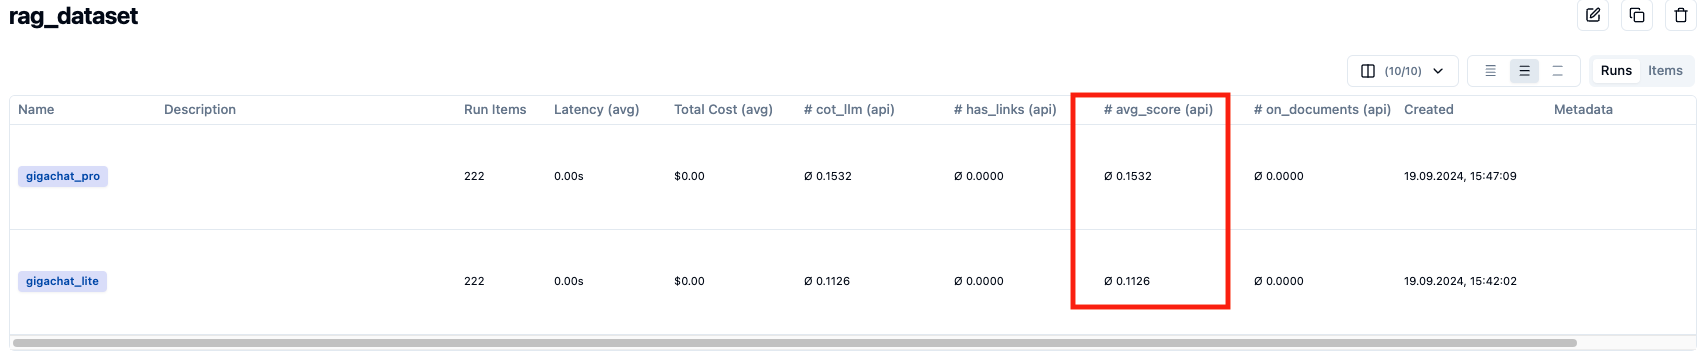

Судя по всему GigaChat хорошо справляется с вопросами сам о себе, но про GigaChain отвечает слабо.
Теперь попробуем прогнать датасет с простым RAG

### Оценка ответов GigaChat + RAG(стандартный)
Для начала инициализируем векторную базу данных. В этом примере используется внешняя БД Pinecone

In [19]:
from langchain_pinecone import PineconeVectorStore
from langchain_community.embeddings.gigachat import GigaChatEmbeddings
from pinecone import Pinecone

pinecone_api_key = os.environ.get("PINECONE_API_KEY")

pc = Pinecone(api_key=pinecone_api_key)
index = pc.Index("gigachain-test-index-gigar")

embeddings = GigaChatEmbeddings(model="EmbeddingsGigaR")
vector_store = PineconeVectorStore(index=index, embedding=embeddings)

## Собираем цепочку с RAG
### Классический RAG без документов

In [22]:
from langchain_core.runnables import RunnablePassthrough
from langchain.chains.question_answering.stuff_prompt import CHAT_PROMPT


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


vector_store.as_retriever().invoke("Как обновить GigaChain?")

rag_chain = (
    {
        "context": vector_store.as_retriever() | format_docs,
        "question": RunnablePassthrough(),
    }
    | CHAT_PROMPT
    | giga_pro
    | StrOutputParser()
)

In [23]:
rag_chain.invoke("Как обновить GigaChain?")

'Выполните команду bash pip install -U gigachain_community'

In [24]:
from langchain_core.runnables import RunnableParallel

rag_chain = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | CHAT_PROMPT
    | giga_pro
    | StrOutputParser()
)

rag_chain_with_source = RunnableParallel(
    {"context": vector_store.as_retriever(), "question": RunnablePassthrough()}
).assign(answer=rag_chain)

rag_chain_with_source.invoke("Как обновить GigaChain?")

{'context': [Document(metadata={'source': 'https://giga.chat/help/articles/faq'}, page_content='Как обновить GigaChain?\n\nВыполните команду bash pip install -U gigachain_community\n\n## Как установить gigachain\n\nВыполните команду bash pip install gigachain_community\n\n## Как обновиться с langchain на gigachain Нужно создать чистое виртуальное окружение python и активировать его. Для Mac/Linux, например так: bash python -m venv venv source venv/bin/activate\n\nДалее можно установить gigachain: bash pip install gigachain_community\n\nРучное удаление langchain не рекомендуется.\n\n## Как установить LangGraph bash pip install langgraph'),
  Document(metadata={'source': 'https://courses.sberuniversity.ru/llm-gigachat/'}, page_content='4.1 Что такое GigaChain и как его установить\n\nВведение\n\nGigaChain SDK — это библиотека инструментов для упрощения и автоматизации работы c GigaChat. Информация из этого урока и далее будет полезна, прежде всего, разработчикам, которые занимаются интегр

In [82]:
await evaluate("rag_gigar", rag_chain_with_source)


100%|██████████| 74/74 [06:55<00:00,  5.62s/it]


![image-2.png](media/llm_with_rag.jpeg)

Оценка - 0.71

### Оценка ответов GigaChat + Adaptive RAG
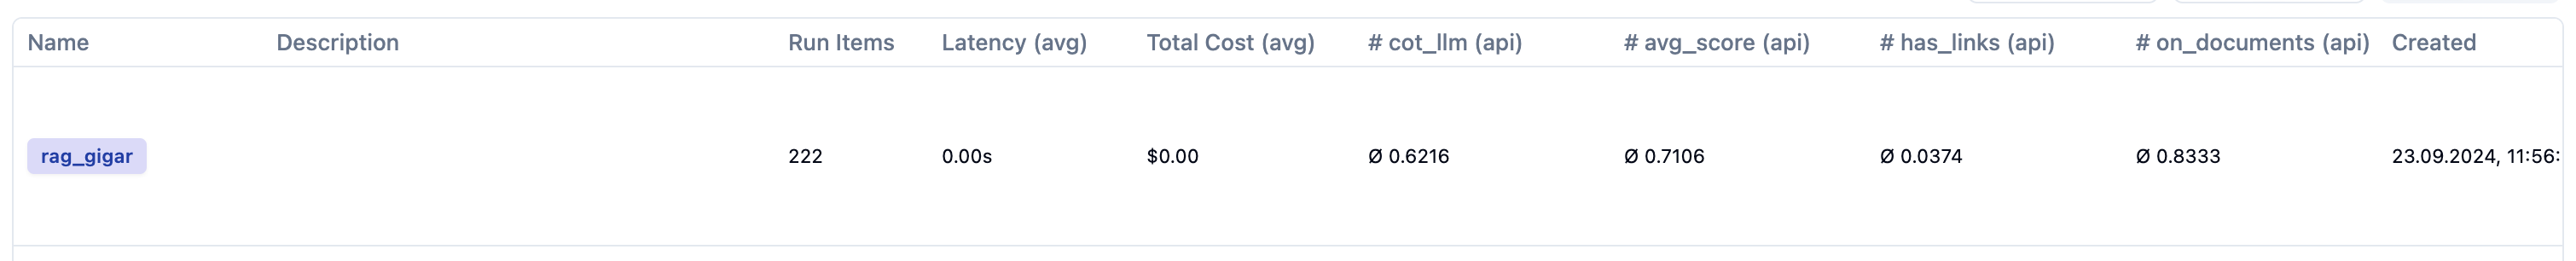

In [6]:
from graph import graph, GraphState

generation = await graph.ainvoke(input=GraphState(question="Как обновить GigaChain?"))
print(generation['generation'])

/Users/19563044/Documents/giga/gigachain_telegram_bot/venv/lib/python3.12/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Конечно, вот улучшенный ответ:

Для обновления GigaChain выполните следующую команду в терминале:
```bash
pip install -U gigachain_community
```
Это обновит вашу установку до последней версии. Если у вас есть другие вопросы или нужна помощь, пожалуйста, дайте знать!


In [11]:
await evaluate("arag_gigar", graph, graph=True)

 54%|█████▍    | 40/74 [02:26<01:32,  2.72s/it]

(URL('https://wmapi-ift.saluteai-pd.sberdevices.ru/v1/chat/completions'), 500, b'{"status":500,"message":"Internal Server Error"}\n', Headers({'server': 'nginx', 'date': 'Tue, 24 Sep 2024 08:00:32 GMT', 'content-type': 'application/json; charset=utf-8', 'content-length': '49', 'connection': 'keep-alive', 'keep-alive': 'timeout=15', 'access-control-allow-credentials': 'true', 'access-control-allow-headers': 'Origin, X-Requested-With, Content-Type, Accept, Authorization', 'access-control-allow-methods': 'GET, POST, DELETE, OPTIONS', 'access-control-allow-origin': 'https://beta.saluteai.sberdevices.ru', 'x-request-id': '7a9f80a6-c5d8-4d89-b43d-56e891cef00a', 'x-session-id': '7b38898a-c810-4e73-92cc-8f8a6f627bc5', 'x-sp-crid': '1851564027:2'}))


100%|██████████| 74/74 [04:09<00:00,  3.37s/it]


Смотрим результат...
![image-2.png](media/llm_with_arag.jpeg)
Результат вышел `0.59`, меньше чем у просто RAG.
Почему?
Дело в том, что ARAG сам выбирает относиться ли вопрос к нашей векторной базе данных,
и может отказаться от ответа, не обращаясь к ней. Здесь качество зависит от качества промпта
который направляет запрос в графе.
### Оценка ответов Support Bot
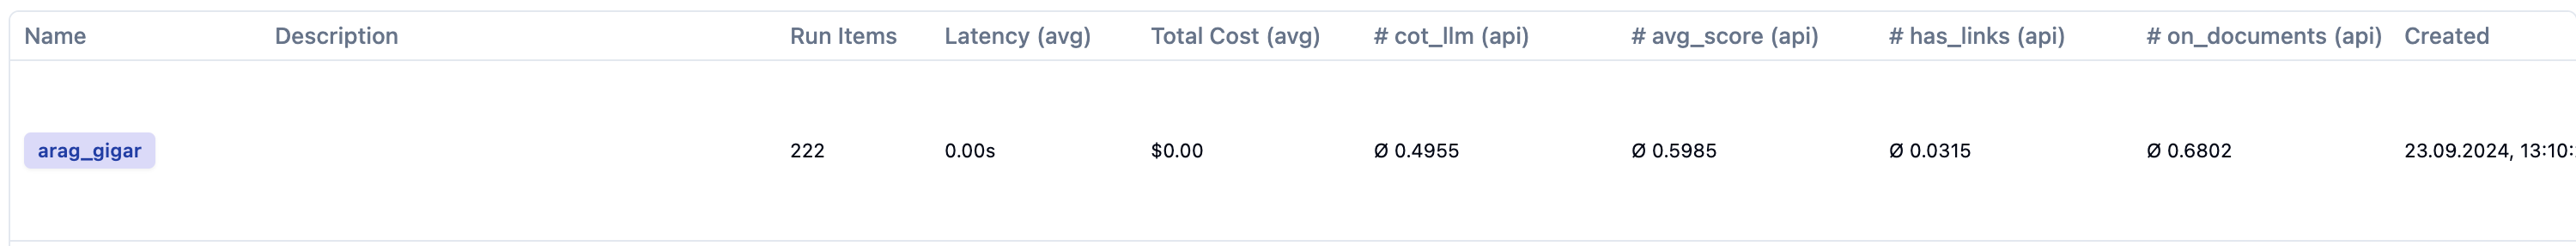

In [87]:
from graph_2 import graph as graph_2
(await graph_2.ainvoke(input=GraphState(question="Как обновить GigaChain?")))['generation']

'Для обновления GigaChain выполните команду `bash pip install -U gigachain_community`. Дополнительную информацию и примеры использования GigaChain можно найти в следующих ресурсах:\n\n- Документация по API: [https://developers.sber.ru/docs/ru/gigachat/api/overview](https://developers.sber.ru/docs/ru/gigachat/api/overview)\n- Репозиторий GigaChain на GitHub: [https://github.com/ai-forever/gigachain](https://github.com/ai-forever/gigachain)\n- Курс по LLM GigaChat: [https://courses.sberuniversity.ru/llm-gigachat/](https://courses.sberuniversity.ru/llm-gigachat/)\n\nЭти ресурсы предоставят подробные руководства и примеры кода для работы с GigaChain.'

In [88]:
await evaluate("support_bot_v2_gigar_2", graph_2, graph=True)

100%|██████████| 74/74 [16:07<00:00, 13.07s/it]


Смотрим результат...
![image.png](media/llm_with_support_bot.jpeg)
Результат вышел `0.75`.
На данный момент эта версия дает наилучшее качество